# Validate embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 18:45:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/08 18:45:27 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


### embeddings

In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/process/

Mon Apr  8 18:45:39 UTC 2024
gs://dsgt-clef-plantclef-2024/data/process/subset_training_cropped_resized_v2/
gs://dsgt-clef-plantclef-2024/data/process/training_cropped_resized_v2/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train = "PlantCLEF2024_training_cropped_resized_v2"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)

# Show the data
train_df.show(n=5)

+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path| organ|species_id|    obs_id|             license|partner|              author|altitude|     latitude|    longitude|gbif_species_id|             species|     genus|       family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|
+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+-----------

### subset data

In [5]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/process"
dino_emb_train = "subset_training_cropped_resized_v2/dino/data"
dct_emb_train = "subset_training_cropped_resized_v2/dino_dct/data"

# Define the GCS path to the embedding files
dino_gcs_path = f"{gcs_path}/{dino_emb_train}"
dct_gcs_path = f"{gcs_path}/{dct_emb_train}"

# Read the Parquet file into a DataFrame
dino_df = spark.read.parquet(dino_gcs_path)
dct_df = spark.read.parquet(dct_gcs_path)

# Show the data
dino_df.show(n=5, truncate=50)
dct_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+---------+
|                                  image_name|species_id|                                    dino_embedding|sample_id|
+--------------------------------------------+----------+--------------------------------------------------+---------+
|e65da68edf01432daacdc5ab3890dd217fa371ce.jpg|   1355927|[1.1890908, -0.47639695, -0.44213566, -1.302010...|        5|
|d61f7d5ba5a3554cbdbe4ae698bf91841045a25f.jpg|   1361703|[-1.4935707, -2.276459, 1.8699003, 1.4622146, 0...|        5|
|b55156e4980285a051f869fd9373a2e1eee41b15.jpg|   1355927|[1.9725426, 0.42123017, -0.34139654, 1.9770608,...|        5|
|2fb34c40832bffad3b827eb785ab3fa06f218cd3.jpg|   1361703|[-1.4597725, 0.30644566, 0.69400734, -0.8678096...|        5|
|dcfbf0a9d4e41c0548d3e2746e7dbfad00d83712.jpg|   1355927|[-1.0584896, -2.6023614, 0.04883358, 1.1083963,...|        5|
+--------------------------------------------+--

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                     dct_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|3b52d49b6264fcc75020337466341fe8ea55101c.jpg|   1355927|[-27288.61, -1395.3291, -11721.64, 8081.321, 26...|
|7b191f510cc058cfbbd1bcb13ee2581d772ab256.jpg|   1355927|[-18450.082, 19951.092, 6919.084, 35483.668, 16...|
|d06f0fafaefece5b9e020c65a4e7517636f713c2.jpg|   1361703|[-16422.531, 17368.383, -19494.031, -61953.766,...|
|7fb51e4f3c0798df122a3736dc123f3c854c6c23.jpg|   1361703|[-26989.59, -6447.115, 20485.979, 16501.512, 12...|
|dcfbf0a9d4e41c0548d3e2746e7dbfad00d83712.jpg|   1355927|[-17286.598, 8335.439, 8180.4746, 31488.94, 515...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

In [6]:
# Join with dino_df with train_df to get species names
dino_joined_df = dino_df.join(train_df, "image_name", "inner").select(
    [
        dino_df["image_name"],
        train_df["species"],
        dino_df["species_id"],
        dino_df["dino_embedding"],
    ]
)
dino_joined_df.show(n=5)

# Join dct_df with train_df to get species names
dct_joined_df = dct_df.join(train_df, "image_name", "inner").select(
    [
        dct_df["image_name"],
        train_df["species"],
        dct_df["species_id"],
        dct_df["dct_embedding"],
    ]
)

+--------------------+--------------------+----------+--------------------+
|          image_name|             species|species_id|      dino_embedding|
+--------------------+--------------------+----------+--------------------+
|2b7b871b5572ff46e...|Arctotheca calend...|   1355927|[0.26519457, -0.9...|
|2fb34c40832bffad3...|Posidonia oceanic...|   1361703|[-1.4597725, 0.30...|
|621e686326c070ba8...|Posidonia oceanic...|   1361703|[-1.41049, -0.224...|
|626237693bbfb18aa...|Posidonia oceanic...|   1361703|[-0.65176105, -3....|
|640925bcefc42d9fa...|Posidonia oceanic...|   1361703|[-0.34327254, -0....|
+--------------------+--------------------+----------+--------------------+
only showing top 5 rows



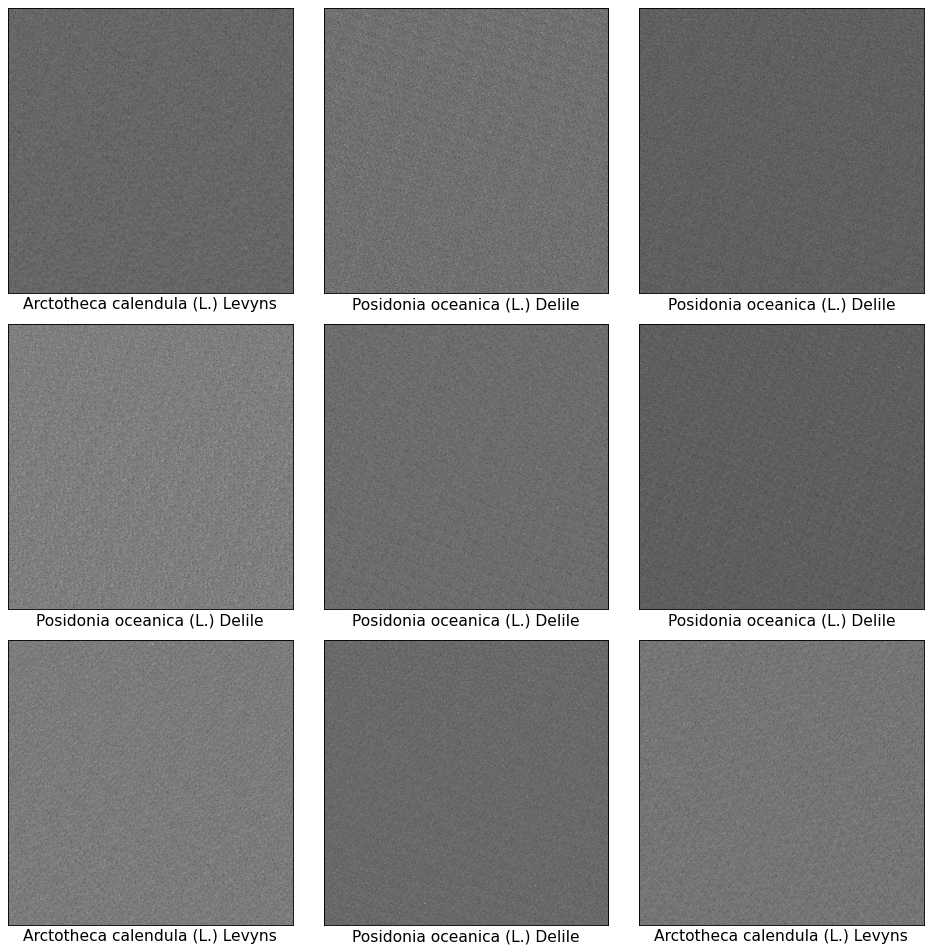

In [7]:
from plantclef.plotting import plot_images_from_embeddings

# Plot DINO image embeddings
plot_images_from_embeddings(
    dino_joined_df, data_col="dino_embedding", image_col="species", grid_size=(3, 3)
)

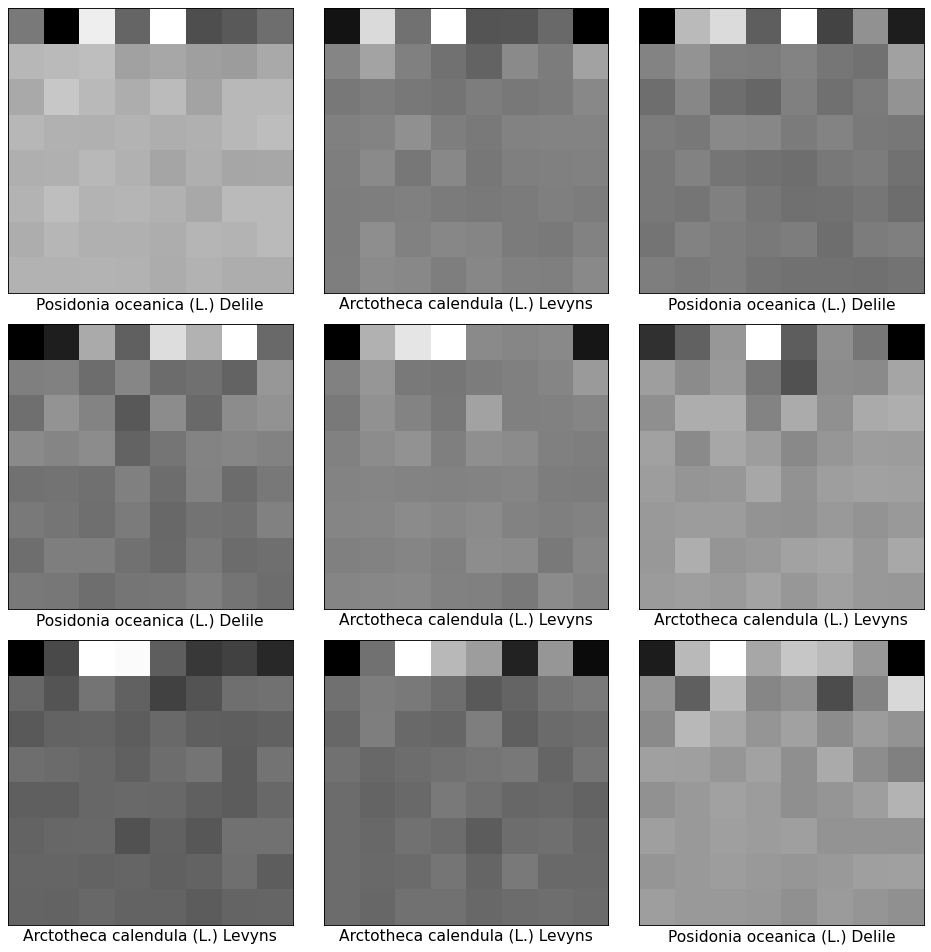

In [8]:
# Plot DCT image embeddings
plot_images_from_embeddings(
    dct_joined_df, data_col="dct_embedding", image_col="species", grid_size=(3, 3)
)

### full-size train data

In [9]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/process"
dino_emb_train = "training_cropped_resized_v2/dino/data"
dct_emb_train = "training_cropped_resized_v2/dino_dct/data"

# Define the GCS path to the embedding files
dino_gcs_path = f"{gcs_path}/{dino_emb_train}"
dct_gcs_path = f"{gcs_path}/{dct_emb_train}"

# Read the Parquet file into a DataFrame
dino_df = spark.read.parquet(dino_gcs_path)
dct_df = spark.read.parquet(dct_gcs_path)

# Show the data
dino_df.show(n=5, truncate=50)
dct_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+---------+
|                                  image_name|species_id|                                    dino_embedding|sample_id|
+--------------------------------------------+----------+--------------------------------------------------+---------+
|8384311a03a9cff67a54a2825dbeb4d3e8a891a3.jpg|   1397608|[0.75137013, 0.3275455, 1.6707572, 0.45285824, ...|        9|
|b38e87b2a2bcfeefcbc6adbeb4aad0437b9e1839.jpg|   1397608|[0.35812917, 1.4896353, 2.4680657, 0.7175607, 0...|        9|
|b56d8dc9553c1014cb6aecffa93c734aaa997ccf.jpg|   1363992|[1.5729619, -0.0512933, 0.5113419, -1.4510978, ...|        9|
|ff815358961d1c0dbd1a95e1ac5f9dff0e5e13fc.jpg|   1358357|[1.8277985, 0.011137103, -0.058480255, -0.32846...|        9|
|e2b977b6461d35a266c28806cb75e11930614866.jpg|   1363814|[0.37129048, -1.4583586, -3.1828911, 1.3645148,...|        9|
+--------------------------------------------+--

In [13]:
dino_count = dino_df.count()
dct_count = dct_df.count()

print(f"DINO count: {dino_count}")
print(f"DCT count:  {dct_count}")

DINO count: 1408033
DCT count:  1408033


In [14]:
dino_df.groupBy("sample_id").count().select("sample_id", "count").show()

+---------+------+
|sample_id| count|
+---------+------+
|        9|139429|
|        3|148106|
|        7|136313|
|        0|145868|
|        4|130862|
|        5|143432|
|        8|139638|
|        6|141458|
|        1|148260|
|        2|134667|
+---------+------+

